In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from tqdm import tqdm
import numpy as np
from sklearn.cluster import DBSCAN
import plotly.express as px

sys.path.append('../utils')
import helpers as h
import feature_engineering as f

In [2]:
ITM_DIR = os.path.join(os.getcwd(), '../data/intermediate')

PH = 1100   #Height for plotly (adapt to your screen) #TODO;: implement as JSON config param
PW = 1000   #Width for plotly  (adapt to your screen) #TODO;: implement as JSON config param

In [3]:
request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))

C:\Users\adind\AppData\Local\Temp\ipykernel_4112\291413550.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))


In [4]:
# add route stop distances as feature
request_df = f.calculate_distances(request_df, 'stop_order')

100%|██████████| 18010/18010 [00:59<00:00, 304.16it/s]


In [5]:
## add route centers as feature. 
request_df = f.get_route_center(request_df)

In [6]:
# extract weekday from route_date and add as column
request_df['route_date'] = pd.to_datetime(request_df['route_date'])
request_df['weekday'] = request_df['route_date'].dt.day_name()

In [4]:
selection = "0521_621-20220616"
request_df.query('dir == @selection').shape# add gets_dropped as feature. 


(1037, 26)

In [9]:
initial_dfs = []
for _, df in request_df.query('dir == @selection').groupby('dir'):

    # Time is the timestamp coming from serverlog: compare first request wiht last non-PM request
    # REMEMBER THAT: PM requests where filtered out already.
    first_request_timestamp = df['Time'].min()
    last_request_timestamp = df['Time'].max()
    # get the first and last request as dfs: 
    first_request_df = df.loc[df['Time'] == first_request_timestamp]
    print(first_request_df.shape)
    last_request_df = df.loc[df['Time'] == last_request_timestamp]
    print(last_request_df.shape)

    # Only interested in dropped for generating MLs on dropping stops. 
    # ==> Someone: run statistics on common, added, dropped. 
    common, added, dropped = f.stop_diffs(first_request_df, last_request_df)
    print(len(common), len(added), len(dropped))
    # #add the column "gets_dropped" to first_request_df and set it to 1 if first_request_df.id is in dropped else 0
    # first_request_df['gets_dropped'] = first_request_df['id'].apply(lambda x: 1 if x in dropped else 0)
    # # initial_dfs.append(first_request_df)

initial_routes_df = pd.concat(initial_dfs)
initial_routes_df

(155, 26)
(142, 26)
137 5 18


ValueError: No objects to concatenate

In [10]:
# add gets_dropped as feature. 
initial_dfs = []
for _, df in request_df.groupby('dir'):
    # Time is the timestamp coming from serverlog: compare first request wiht last non-PM request
    # REMEMBER THAT: PM requests where filtered out already.
    first_request_timestamp = df['Time'].min()
    last_request_timestamp = df['Time'].max()
    # get the first and last request as dfs: 
    first_request_df = df.loc[df['Time'] == first_request_timestamp]
    last_request_df = df.loc[df['Time'] == last_request_timestamp]
    
    # Only interested in dropped for generating MLs on dropping stops. 
    # ==> Someone: run statistics on common, added, dropped. 
    common, added, dropped = f.stop_diffs(first_request_df, last_request_df)
    #add the column "gets_dropped" to first_request_df and set it to 1 if first_request_df.id is in dropped else 0
    first_request_df['gets_dropped'] = first_request_df['id'].apply(lambda x: 1 if x in dropped else 0)
    initial_dfs.append(first_request_df)

initial_routes_df = pd.concat(initial_dfs)
initial_routes_df

C:\Users\adind\AppData\Local\Temp\ipykernel_4112\1951510245.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_request_df['gets_dropped'] = first_request_df['id'].apply(lambda x: 1 if x in dropped else 0)
C:\Users\adind\AppData\Local\Temp\ipykernel_4112\1951510245.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_request_df['gets_dropped'] = first_request_df['id'].apply(lambda x: 1 if x in dropped else 0)
C:\Users\adind\AppData\Local\Temp\ipykernel_4112\1951510245.py:16: SettingWithCopyWarn

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,Time,OptimizationRequestId,RouteId,TriggerType,ConfigurationName,NumberOfTasks,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last,gets_dropped
0,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,394,0.565826,0.221868,2022-06-17T07:30:00,2022-06-17T18:00:00,2,1,0521_300-20220617,...,1900-01-01 05:57:33.231000,41931cd2-8975-4a64-9197-d16abe871bb7,0521_300,FullOptimization,CreateSequence,2.0,0.0,1.0,False,1
1,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,395,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,1,2,0521_300-20220617,...,1900-01-01 05:57:33.231000,41931cd2-8975-4a64-9197-d16abe871bb7,0521_300,FullOptimization,CreateSequence,2.0,0.0,1.0,False,1
6,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64869,0.650488,0.296025,2022-05-30T00:00:00,2022-05-30T12:00:00,1,1,0521_301-20220530,...,1900-01-01 06:45:38.424000,cb9638db-2817-4ccf-b226-7775c01793a8,0521_301,TimeCalculation,EstimateTime,154.0,154.0,1.0,True,0
7,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64947,0.646361,0.297741,2022-05-30T00:00:00,2022-05-30T12:00:00,2,2,0521_301-20220530,...,1900-01-01 06:45:38.424000,cb9638db-2817-4ccf-b226-7775c01793a8,0521_301,TimeCalculation,EstimateTime,154.0,154.0,1.0,True,0
8,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64971,0.645787,0.298443,2022-05-30T00:00:00,2022-05-30T12:00:00,3,3,0521_301-20220530,...,1900-01-01 06:45:38.424000,cb9638db-2817-4ccf-b226-7775c01793a8,0521_301,TimeCalculation,EstimateTime,154.0,154.0,1.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120370,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63656,0.484775,0.297222,2022-06-22T07:30:00,2022-06-22T23:59:00,95,131,0521_O69-20220622,...,1900-01-01 06:41:01.149000,642acef2-3942-4057-aeb8-61df9f7ffa1b,0521_O69,FullOptimization,CreateSequence,135.0,0.0,1.0,False,0
2120371,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63654,0.486119,0.297154,2022-06-22T07:30:00,2022-06-22T23:59:00,97,132,0521_O69-20220622,...,1900-01-01 06:41:01.149000,642acef2-3942-4057-aeb8-61df9f7ffa1b,0521_O69,FullOptimization,CreateSequence,135.0,0.0,1.0,False,0
2120372,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63653,0.485895,0.296226,2022-06-22T07:30:00,2022-06-22T23:59:00,98,133,0521_O69-20220622,...,1900-01-01 06:41:01.149000,642acef2-3942-4057-aeb8-61df9f7ffa1b,0521_O69,FullOptimization,CreateSequence,135.0,0.0,1.0,False,0
2120373,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63652,0.485559,0.295839,2022-06-22T07:30:00,2022-06-22T23:59:00,99,134,0521_O69-20220622,...,1900-01-01 06:41:01.149000,642acef2-3942-4057-aeb8-61df9f7ffa1b,0521_O69,FullOptimization,CreateSequence,135.0,0.0,1.0,False,0


In [15]:
selection = "0521_621-20220616"
initial_routes_df.loc[initial_routes_df["dir"] == selection].shape

(155, 27)

In [18]:
(initial_routes_df.loc[initial_routes_df["dir"] == selection]).query('gets_dropped == 1').shape

(18, 27)

In [13]:
initial_routes_df.loc[initial_routes_df["dir"] == selection].head()

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,Time,OptimizationRequestId,RouteId,TriggerType,ConfigurationName,NumberOfTasks,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last,gets_dropped
724889,f952e93a-5019-47f3-aa0f-08a392f47c8c,CreateSequence,155554,0.661441,0.240444,2022-06-16T07:30:00,2022-06-16T23:59:00,120,1,0521_621-20220616,...,1900-01-01 05:14:18.203000,f952e93a-5019-47f3-aa0f-08a392f47c8c,0521_621,FullOptimization,CreateSequence,155.0,0.0,1.0,False,0
724890,f952e93a-5019-47f3-aa0f-08a392f47c8c,CreateSequence,155515,0.665385,0.240905,2022-06-16T07:30:00,2022-06-16T23:59:00,61,2,0521_621-20220616,...,1900-01-01 05:14:18.203000,f952e93a-5019-47f3-aa0f-08a392f47c8c,0521_621,FullOptimization,CreateSequence,155.0,0.0,1.0,False,1
724891,f952e93a-5019-47f3-aa0f-08a392f47c8c,CreateSequence,155560,0.665921,0.240851,2022-06-16T07:30:00,2022-06-16T23:59:00,60,3,0521_621-20220616,...,1900-01-01 05:14:18.203000,f952e93a-5019-47f3-aa0f-08a392f47c8c,0521_621,FullOptimization,CreateSequence,155.0,0.0,1.0,False,0
724892,f952e93a-5019-47f3-aa0f-08a392f47c8c,CreateSequence,155602,0.666161,0.240969,2022-06-16T07:30:00,2022-06-16T23:59:00,59,4,0521_621-20220616,...,1900-01-01 05:14:18.203000,f952e93a-5019-47f3-aa0f-08a392f47c8c,0521_621,FullOptimization,CreateSequence,155.0,0.0,1.0,False,0
724893,f952e93a-5019-47f3-aa0f-08a392f47c8c,CreateSequence,155561,0.667057,0.241041,2022-06-16T10:00:00,2022-06-16T11:00:00,15,5,0521_621-20220616,...,1900-01-01 05:14:18.203000,f952e93a-5019-47f3-aa0f-08a392f47c8c,0521_621,FullOptimization,CreateSequence,155.0,0.0,1.0,False,0


In [19]:
initial_routes_df.shape

(400393, 27)

In [21]:
# Group by col1
summary = initial_routes_df.groupby('dir')['gets_dropped'].agg(
    total_rows='count',
    num_zeros=lambda x: (x == 0).sum(),
    num_ones=lambda x: (x == 1).sum()
).reset_index()

# Add percentage of ones
summary['pct_ones'] = (summary['num_ones'] / summary['total_rows']) * 100
summary.shape

(3312, 5)

In [22]:
summary.head()

,dir,total_rows,num_zeros,num_ones,pct_ones
0,0521_300-20220617,2,0,2,100.000000
1,0521_301-20220530,154,154,0,0.000000
2,0521_301-20220531,159,148,11,6.918239
3,0521_301-20220601,135,131,4,2.962963
4,0521_301-20220602,139,133,6,4.316547


In [23]:
summary.to_excel("../data/intermediate/summary.xlsx")

In [33]:
aa_mean = summary["total_rows"].mean()
aa_median = summary["total_rows"].median()
print("mean", aa_mean, "/ median", aa_median)

mean 120.89160628019323 / median 124.0


In [34]:
bb_mean = summary["num_ones"].mean()
bb_median = summary["num_ones"].median()
print("mean", bb_mean, "/ median", bb_median)

mean 17.59722222222222 / median 4.0


In [35]:
cc_mean = summary["pct_ones"].mean()
cc_median = summary["pct_ones"].median()
print("mean", cc_mean, "/ median", cc_median)

mean 12.074200957311666 / median 3.597122302158273


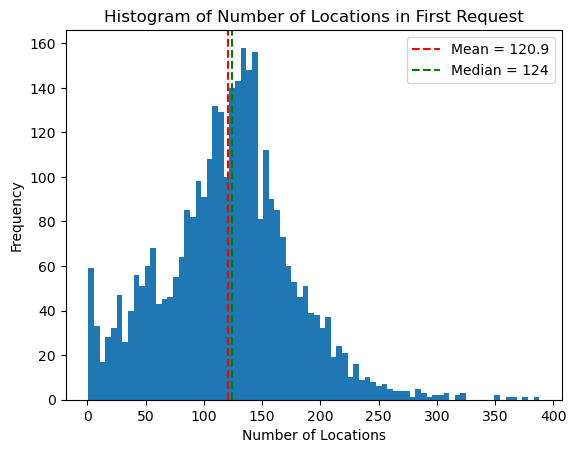

In [29]:
plt.hist(summary["total_rows"], bins=80)
plt.title('Histogram of Number of Locations in First Request')
plt.xlabel('Number of Locations')
plt.ylabel('Frequency')

plt.axvline(aa_mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean = {aa_mean:.1f}')
plt.axvline(aa_median, color='green', linestyle='dashed', linewidth=1.5, label=f'Median = {aa_median:.0f}')


# Add legend
plt.legend()

plt.show()

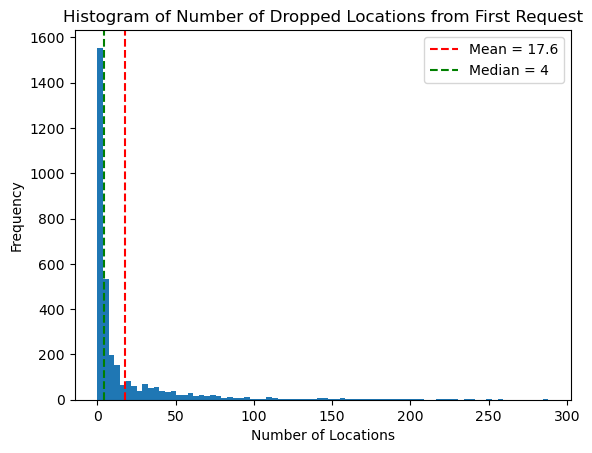

In [30]:
plt.hist(summary["num_ones"], bins=80)
plt.title('Histogram of Number of Dropped Locations from First Request')
plt.xlabel('Number of Locations')
plt.ylabel('Frequency')

plt.axvline(bb_mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean = {bb_mean:.1f}')
plt.axvline(bb_median, color='green', linestyle='dashed', linewidth=1.5, label=f'Median = {bb_median:.0f}')


# Add legend
plt.legend()

plt.show()

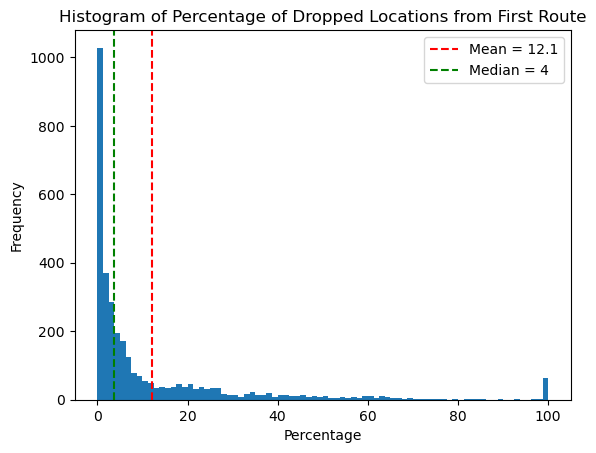

In [32]:
plt.hist(summary["pct_ones"], bins=80)
plt.title('Histogram of Percentage of Dropped Locations from First Route')
plt.xlabel('Percentage')
plt.ylabel('Frequency')

plt.axvline(cc_mean, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean = {cc_mean:.1f}')
plt.axvline(cc_median, color='green', linestyle='dashed', linewidth=1.5, label=f'Median = {cc_median:.0f}')


# Add legend
plt.legend()

plt.show()

      route_id weekday  count
959   0521_O18  Monday    226
374   0521_634  Monday    285
1026  0521_O36  Monday     16
1089  0521_O54  Monday    191
164   0521_364  Monday    204
599   0521_688  Monday    295
751   0521_881  Monday     52
169   0521_365  Monday    346
369   0521_633  Monday    161
605   0521_689  Monday    234


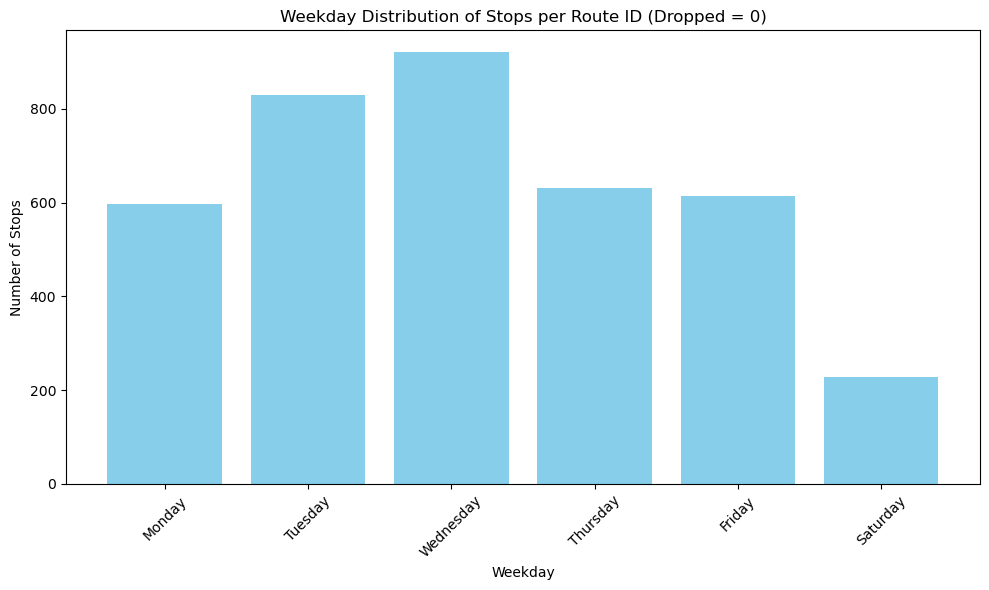

In [8]:
# Filter initial_routes_df where dropped = 0
filtered_df = initial_routes_df[initial_routes_df['gets_dropped'] == 0]

# Define the correct weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Give row count per route_id and weekday
weekday_counts = filtered_df.groupby(['route_id', 'weekday']).size().reset_index(name='count')

# Convert 'weekday' column to a categorical type with the specified order
weekday_counts['weekday'] = pd.Categorical(weekday_counts['weekday'], categories=weekday_order, ordered=True)

# Sort by the categorical weekday order
weekday_counts = weekday_counts.sort_values(by=['weekday'])

# Print the first 10 rows
print(weekday_counts.head(10))

# Plot weekday distribution per route_id
plt.figure(figsize=(10, 6))
plt.bar(weekday_counts['weekday'], weekday_counts['count'], color='skyblue')
plt.xlabel('Weekday')
plt.ylabel('Number of Stops')
plt.title('Weekday Distribution of Stops per Route ID (Dropped = 0)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

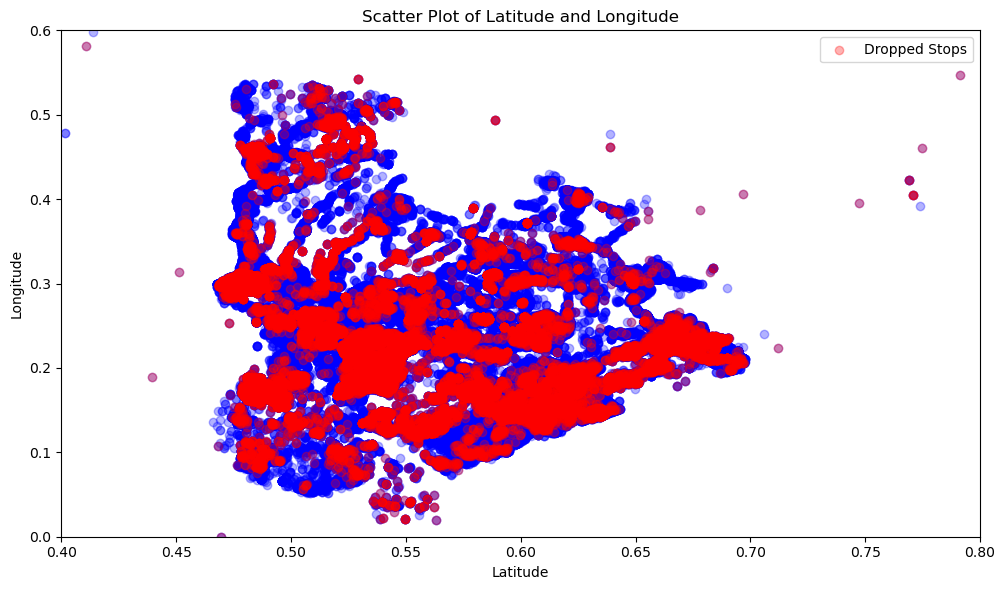

In [9]:
# plot all combinations of latitude and longitude
plt.figure(figsize=(10, 6))
plt.scatter(initial_routes_df['lat'], initial_routes_df['long'], alpha=0.3, c='blue')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Scatter Plot of Latitude and Longitude')
plt.tight_layout()

# highlight the dropped stops in red
plt.scatter(initial_routes_df[initial_routes_df['gets_dropped'] == 1]['lat'], 
            initial_routes_df[initial_routes_df['gets_dropped'] == 1]['long'], 
            alpha=0.3, c='red', label='Dropped Stops')
plt.legend()


# limit axes to the area of interest
plt.xlim(0.4, 0.8)
plt.ylim(0, 0.6)    
plt.show()

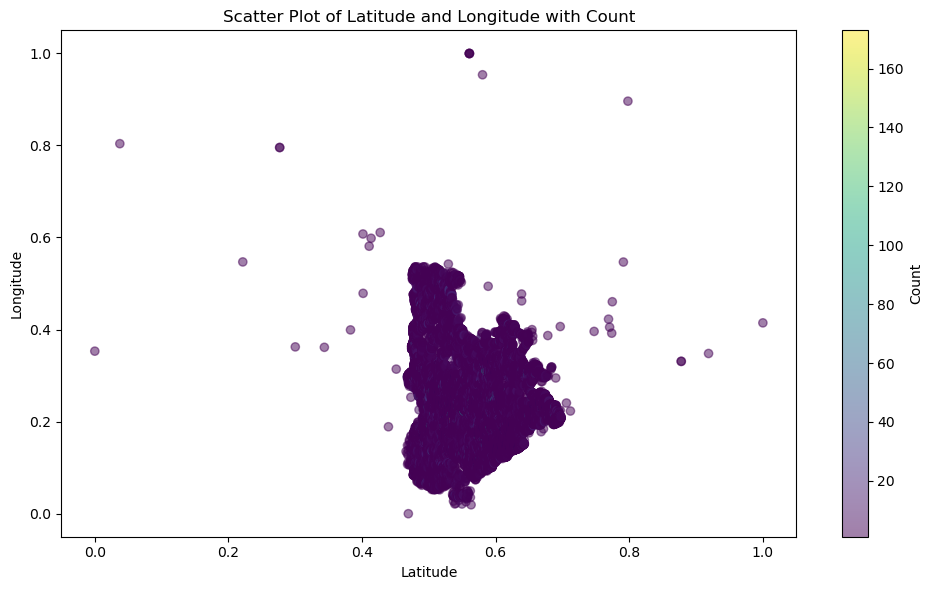

In [10]:
# calculate count of each combination of latitude and longitude
df = initial_routes_df.groupby(['lat', 'long']).size().reset_index(name='count')

# plot all combinations of latitude and longitude but not where dropped = 1 and show count per combination
plt.figure(figsize=(10, 6))
plt.scatter(df['lat'], df['long'], c=df['count'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Count')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Scatter Plot of Latitude and Longitude with Count')
plt.tight_layout()
plt.show()

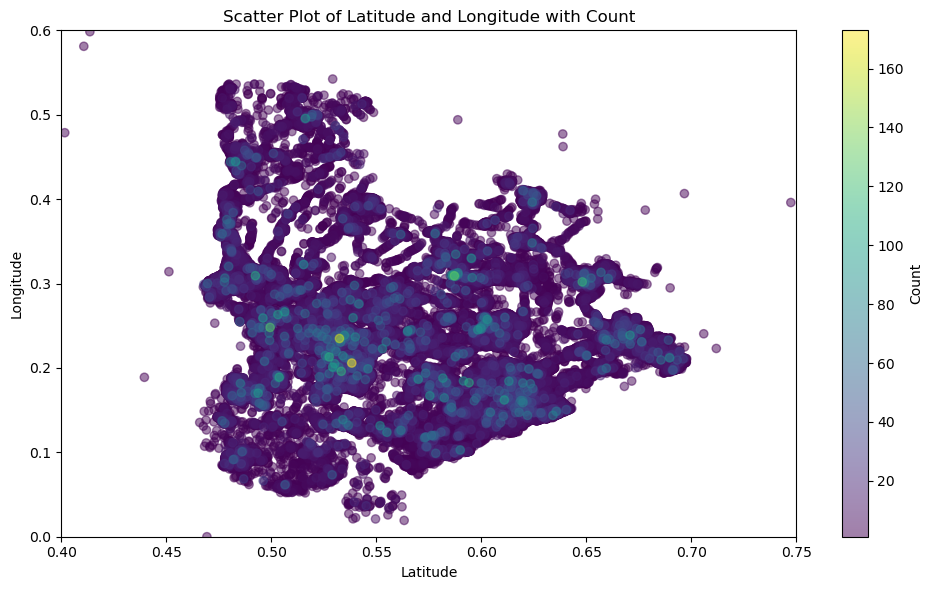

In [11]:
# Calculate count of each combination of latitude and longitude
df = initial_routes_df.groupby(['lat', 'long']).size().reset_index(name='count')

# Sort the DataFrame by 'count' in ascending order to plot higher counts on top
df = df.sort_values(by='count', ascending=True)

# Plot all combinations of latitude and longitude but not where dropped = 1 and show count per combination
plt.figure(figsize=(10, 6))
plt.scatter(df['lat'], df['long'], c=df['count'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Count')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Scatter Plot of Latitude and Longitude with Count')
plt.tight_layout()

# Limit axes to the area of interest
plt.xlim(0.4, 0.75)
plt.ylim(0, 0.6)
plt.show()

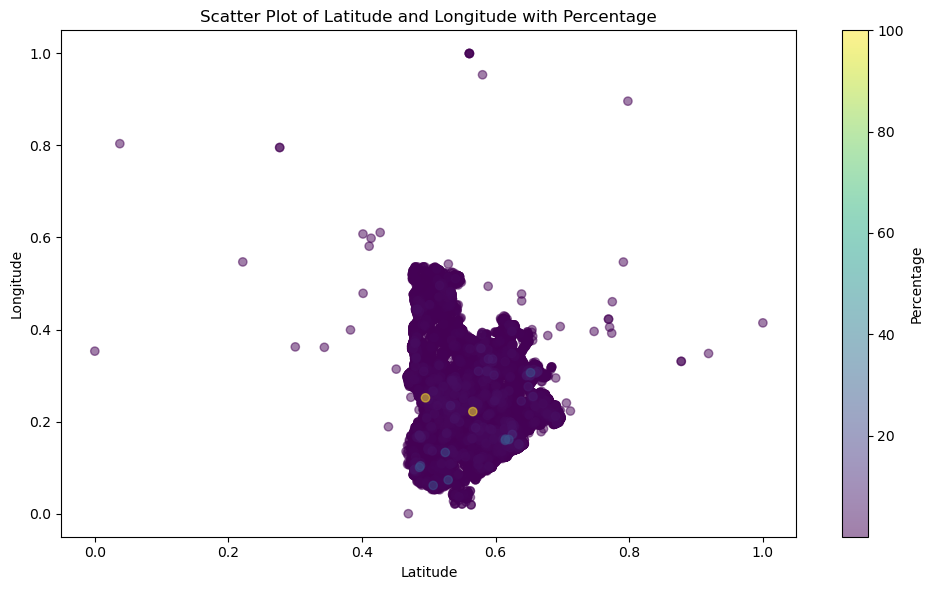

In [12]:
# are there particular lat/lon combinations that are dropped more often than others per route_id?
# calculate count of each combination of latitude and longitude per route_id
df = initial_routes_df.groupby(['route_id', 'lat', 'long']).size().reset_index(name='count')
# calculate the percentage of each combination of latitude and longitude per route_id
df['percentage'] = df['count'] / df.groupby('route_id')['count'].transform('sum') * 100
# sort the DataFrame by 'percentage' in ascending order to plot higher percentages on top
df = df.sort_values(by='percentage', ascending=True)
# plot all combinations of latitude and longitude but not where dropped = 1 and show percentage per combination
plt.figure(figsize=(10, 6))
plt.scatter(df['lat'], df['long'], c=df['percentage'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Percentage')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Scatter Plot of Latitude and Longitude with Percentage')
plt.tight_layout()  

In [13]:
initial_routes_df.columns

Index(['file_uuid', 'configurationName', 'id', 'lat', 'long', 'start_time',
       'end_time', 'server_task_number', 'stop_order', 'dir', 'route_id',
       'route_date', 'idblock_1', 'idblock_2', 'idblock_3', 'internal_id',
       'Date', 'Time', 'OptimizationRequestId', 'RouteId', 'TriggerType',
       'ConfigurationName', 'NumberOfTasks', 'NumberOfTasksInInputPlan',
       'request_day_route_order', 'request_day_route_is_last',
       'dist_since_prev', 'dist_cumulative', 'dist_to_next_stop', 'mean_lat',
       'mean_long', 'dst_point_to_center', 'weekday', 'gets_dropped'],
      dtype='object')

c:\Users\tinne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


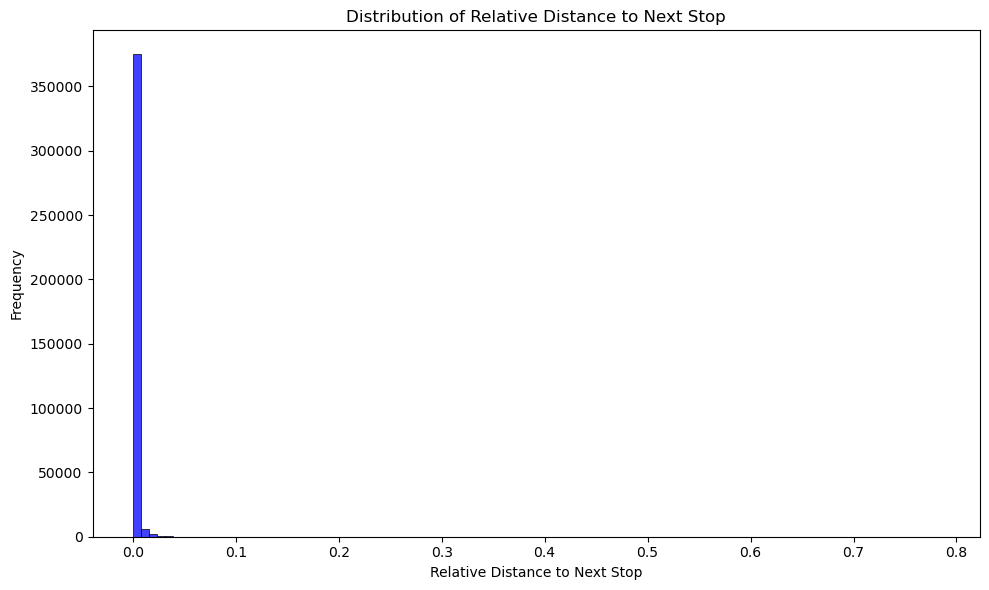

In [14]:
# plot distribution of distance to next stop
plt.figure(figsize=(10, 6))
sns.histplot(initial_routes_df['dist_to_next_stop'], bins=100, kde=False, color='blue')
plt.xlabel('Relative Distance to Next Stop')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Distance to Next Stop')
plt.tight_layout()
plt.show()

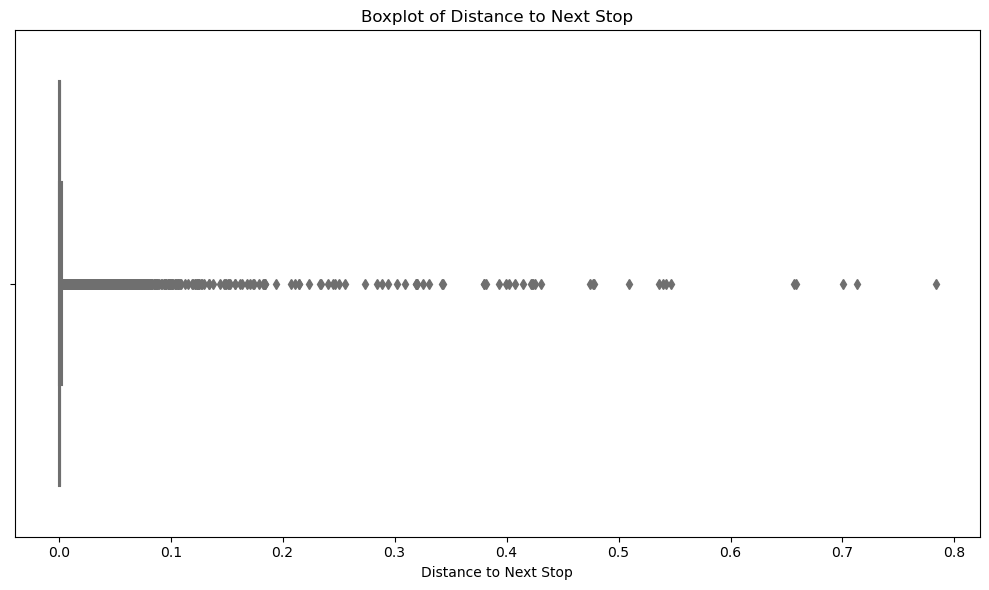

In [15]:
# Boxplot of distance to next stop
plt.figure(figsize=(10, 6))
sns.boxplot(x=initial_routes_df['dist_to_next_stop'], color='skyblue')
plt.xlabel('Distance to Next Stop')
plt.title('Boxplot of Distance to Next Stop')
plt.tight_layout()
plt.show()

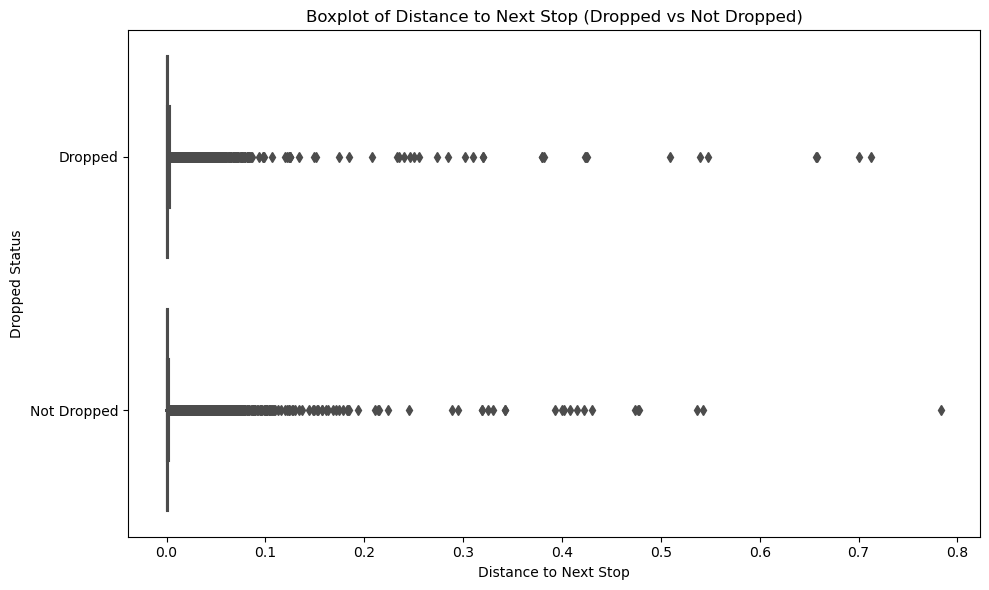

In [17]:
# Overlay boxplots for dropped and non-dropped points
plt.figure(figsize=(10, 6))

# Add a column to differentiate dropped and non-dropped points
initial_routes_df['Dropped_Status'] = initial_routes_df['gets_dropped'].apply(lambda x: 'Dropped' if x == 1 else 'Not Dropped')

# Create the boxplot with hue
sns.boxplot(x='dist_to_next_stop', y='Dropped_Status', data=initial_routes_df, palette={'Dropped': 'red', 'Not Dropped': 'skyblue'})

plt.xlabel('Distance to Next Stop')
plt.ylabel('Dropped Status')
plt.title('Boxplot of Distance to Next Stop (Dropped vs Not Dropped)')
plt.tight_layout()
plt.show()

c:\Users\tinne\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


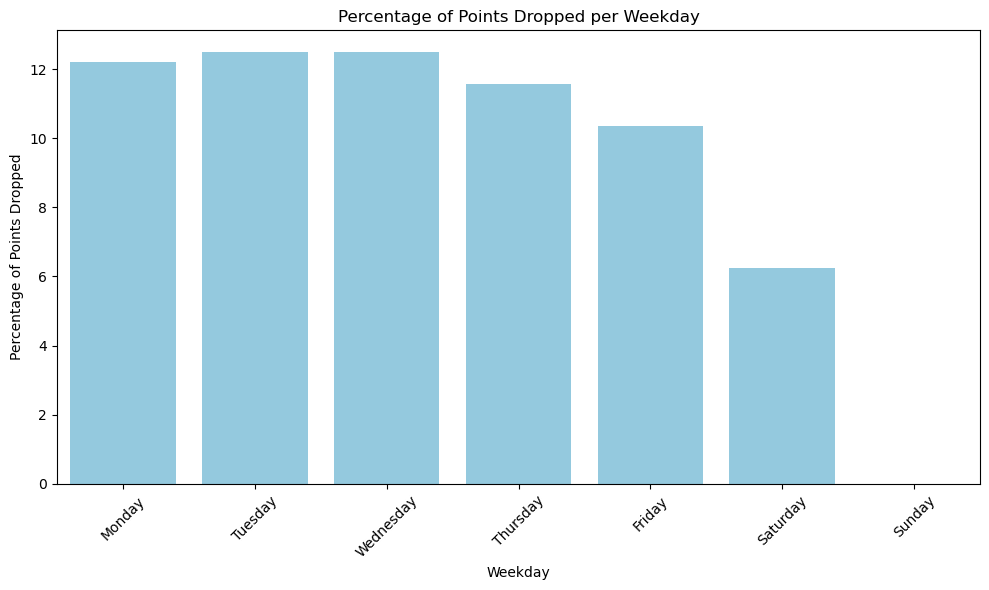

In [18]:
# Calculate percentage of points dropped per weekday
weekday_dropped = initial_routes_df[initial_routes_df['gets_dropped'] == 1].groupby('weekday').size()
weekday_total = initial_routes_df.groupby('weekday').size()

# Calculate percentage
weekday_percentage = (weekday_dropped / weekday_total * 100).reset_index(name='percentage')
weekday_percentage.columns = ['weekday', 'percentage']

# Define the correct weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_percentage['weekday'] = pd.Categorical(weekday_percentage['weekday'], categories=weekday_order, ordered=True)

# Sort by weekday order
weekday_percentage = weekday_percentage.sort_values(by='weekday')

# Plot percentage of points dropped per weekday
plt.figure(figsize=(10, 6))
sns.barplot(x='weekday', y='percentage', data=weekday_percentage, color='skyblue')
plt.xlabel('Weekday')
plt.ylabel('Percentage of Points Dropped')
plt.title('Percentage of Points Dropped per Weekday')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
initial_routes_df

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,request_day_route_is_last,dist_since_prev,dist_cumulative,dist_to_next_stop,mean_lat,mean_long,dst_point_to_center,weekday,gets_dropped,Dropped_Status
0,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,394,0.565826,0.221868,2022-06-17T07:30:00,2022-06-17T18:00:00,2,1,0521_300-20220617,...,False,0.000000,0.000000,0.000000,0.566974,0.223775,0.002225,Friday,1,Dropped
1,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,395,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,1,2,0521_300-20220617,...,False,0.000000,0.000000,NaN,0.566974,0.223775,0.002225,Friday,1,Dropped
6,17647e08-15ab-49ae-aa3f-0987ecc08d93,CreateSequence,65414,0.636873,0.306125,2022-05-31T07:30:00,2022-05-31T23:59:00,143,1,0521_301-20220531,...,False,0.000000,0.000000,0.000000,0.645149,0.305126,0.008335,Tuesday,0,Not Dropped
7,17647e08-15ab-49ae-aa3f-0987ecc08d93,CreateSequence,65411,0.636873,0.306125,2022-05-31T07:30:00,2022-05-31T23:59:00,120,2,0521_301-20220531,...,False,0.000000,0.000000,0.003293,0.645149,0.305126,0.008335,Tuesday,0,Not Dropped
8,17647e08-15ab-49ae-aa3f-0987ecc08d93,CreateSequence,65425,0.640118,0.306687,2022-05-31T07:30:00,2022-05-31T23:59:00,153,3,0521_301-20220531,...,False,0.003293,0.003293,0.000384,0.645149,0.305126,0.005268,Tuesday,0,Not Dropped
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058345,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63656,0.484775,0.297222,2022-06-22T07:30:00,2022-06-22T23:59:00,95,131,0521_O69-20220622,...,False,0.000488,0.124391,0.001346,0.482966,0.303850,0.006870,Wednesday,0,Not Dropped
1058346,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63654,0.486119,0.297154,2022-06-22T07:30:00,2022-06-22T23:59:00,97,132,0521_O69-20220622,...,False,0.001346,0.125737,0.000954,0.482966,0.303850,0.007401,Wednesday,0,Not Dropped
1058347,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63653,0.485895,0.296226,2022-06-22T07:30:00,2022-06-22T23:59:00,98,133,0521_O69-20220622,...,False,0.000954,0.126691,0.000513,0.482966,0.303850,0.008167,Wednesday,0,Not Dropped
1058348,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63652,0.485559,0.295839,2022-06-22T07:30:00,2022-06-22T23:59:00,99,134,0521_O69-20220622,...,False,0.000513,0.127204,0.000000,0.482966,0.303850,0.008420,Wednesday,0,Not Dropped
